# Отток клиентов

##  Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Требуется построить модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки:

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата

Целевой признак:

    Exited — факт ухода клиента

##  Изучение файла с данными

In [228]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,roc_curve, roc_auc_score
from sklearn.utils import shuffle

In [229]:
# Читаем данные из csv-файла в датафрейм и сохраним в переменную data
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [230]:
# Функция для отображения общей информации 
def review(data): 
    info = display(data.head()),data.info(),
    display(data.describe(include='all').round(2).T)
    print('Количество дупликатов:', data.duplicated().sum())   

In [231]:
# Изучим общую информацию о полученном датафрейме
review(data)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,NaN,NaN,NaN,5000.5,2886.9,1.0,2500.75,5000.5,7500.25,10000.0
CustomerId,10000.0,NaN,NaN,NaN,15690940.57,71936.19,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.0,NaN,NaN,NaN,650.53,96.65,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.92,10.49,18.0,32.0,37.0,44.0,92.0
Tenure,9091.0,NaN,NaN,NaN,5.0,2.89,0.0,2.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.89,62397.41,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.53,0.58,1.0,1.0,1.0,2.0,4.0


Количество дупликатов: 0


В таблице 14 столбцов и 10000 строк. В признаке 'Tenure' есть пропущенные значения. Есть несколько категориальных признаков 'Surname', 'Geography' и 'Gender'. Явных дупликатов нет. 

## Предобработка данных

### Работа с названиями столбцов

Приведем названия столбцов к нижнему регистру .

In [232]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]

In [233]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

### Работа с пропущенными значениями 

Заполним пропуски в столбце 'tenure'

In [234]:
# Проверим уникальные значения в столбце 'Tenure'
data['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [235]:
# Заменим пропуски медианным значением и приведем к целочисленному типу
data['tenure'] = data['tenure'].fillna(data['tenure'].median()).astype('int')

### Работа с типами данных

In [236]:
# Приведем столбцы с типом 'float64' к типу данных 'float32'
float64_cols = list(data.select_dtypes(include='float64'))
data[float64_cols] = data[float64_cols].astype('float32')

# Приведем столбцы с типом 'int64' к типу данных 'int32'
int64_cols = list(data.select_dtypes(include='int64'))
data[int64_cols] = data[int64_cols].astype('int32')

### Удаление столбцов

Признаки 'row_number' - индекс строки датафрейма, 'customer_id' и 'surname' - идентификаторы клиента - не несут ценности для обучения будущей модели, поэтому их можно удалить. 

In [237]:
data.drop(['row_number', 'customer_id', 'surname'], inplace=True, axis=1)

In [238]:
# Проверим изменения
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int32  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 820.4+ KB


## Исследование задачи

### Работа с категориальными признаками

Выведем уникальные значения для столбцов 'gender' и 'geography'

In [239]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [240]:
data['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Преобразуем категориальные признаки в численные с помощью техники прямого кодирования OHE. Это позволит нам работать со всеми моделями.

In [241]:
ohe_columns = ['gender', 'geography']
for column in ohe_columns:
    ohe_data = pd.get_dummies(ohe_data, drop_first=True)
    data = pd.merge(
        left=data,
        right=ohe_data,
        left_index=True,
        right_index=True,
    )
    data = data.drop(columns=column)
data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany_x,geography_Spain_x,geography_Germany_y,geography_Spain_y
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1


Столбец 'geography' содержал 3 класса, 'gender'- 2 класса. В результате мы получили только 2 и 1 столбцов соответственно, что позволяет избежать дами-ловушки.

### Разобьем данные на выборки

Разобьем данные столбца 'exited' на признаки и целевой признак, сохраним в отдельных переменных.

In [242]:
target = data['exited']
features = data.drop(['exited'], axis=1)
# Выведем на экран размеры этих переменных
features.shape, target.shape

((10000, 12), (10000,))

Спрятанной тестовой выборки нет. Данные нужно разбить на три части: обучающую, валидационную и тестовую. Для этого исходные данные разбивают в соотношении 3:1:1. Размеры тестового и валидационного наборов обычно равны. Разобьем наши данные на 3 выборки: тренировочную - 60%, тестовую - 20% и валидационную - 20%.

In [243]:
# Разобьем данные на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split\
(features, target, train_size=0.6, random_state=12345, stratify=target)   

In [244]:
# Отделим 20% данных для валидационной выборки
features_test, features_valid, target_test, target_valid = train_test_split\
(features_test, target_test, test_size=0.5, random_state=12345, stratify=target_test)

In [245]:
# Выведем на экран размеры этих выборок
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(features_valid.shape)
print(target_valid.shape)

(6000, 12)
(6000,)
(2000, 12)
(2000,)
(2000, 12)
(2000,)


### Масштабирование признаков

Чтобы алгоритмам было легче обучать модели, приведём признаки к одному масштабу с помощью метода стандартизации данных.

In [246]:
pd.options.mode.chained_assignment = None 
# Определим численные признаки для масштабирования
numeric = ['credit_score', 'age', 'tenure', 'balance','num_of_products', 'estimated_salary']
# Применим на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
# Масштабируем численные признаки тренировочной выборки
features_train[numeric] = scaler.transform(features_train[numeric])
# Масштабируем численные признаки валидационную выборки
features_valid[numeric] = scaler.transform(features_valid[numeric])
# Масштабируем численные признаки тестовой выборки
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany_x,geography_Spain_x,geography_Germany_y,geography_Spain_y
2837,-1.040434,0.953312,0.360600,0.774657,-0.914708,0,1,-0.119110,1,0,1,0
9925,0.454006,-0.095244,-0.002786,1.910540,-0.914708,1,1,-0.258658,0,0,0,0
8746,0.103585,-0.476537,1.087371,0.481608,0.820981,0,1,1.422836,0,0,0,0
660,-0.184996,0.190726,-0.002786,0.088439,-0.914708,1,1,-1.160427,1,0,1,0
3610,-0.720933,1.620574,-1.456328,0.879129,-0.914708,1,0,0.113236,0,0,0,0


В результате мы получили масштабированные признаки для трех выборок. Масштаб у всех признаков теперь одинаковый.

###  Проверим дисбаланс в данных

In [247]:
# Получим количество каждого значения для столбца 'exited' в %
data['exited'].value_counts(normalize=True)*100

0    79.63
1    20.37
Name: exited, dtype: float64

В нашей выборке отрицательных ответов около 80% , положитительных чуть больше 20%. Можно сказать, что имеется дисбаланс данных.

В столбцах 'gender' и 'geography' преобразовали категориальные признаки в численные. Разобили данные столбца 'exited' на признаки и целевой признак, сохранили в отдельных переменных. Чтобы алгоритмам было легче обучать модели, привели признаки к одному масштабу с помощью метода стандартизации данных. Выявили сильный дисбаланс данных.

## Выберем лучшую модель без учета дисбаланса данных

### Дерево решений

In [248]:
best_model_dt = None
best_result_dt = 0
best_depth_dt = 0
best_criterion_dt = 0
best_splitter_dt =  0

for depth in tqdm(range(1,50,1)):    
    for criterion in ['gini', 'entropy']:
        for splitter in ['best', 'random']:
            model = DecisionTreeClassifier(
            random_state=12345,
            criterion=criterion,
            max_depth=depth,
            splitter=splitter   
            )
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            result = f1_score(target_valid, predictions_valid)
            if result > best_result_dt:
                best_model_dt = model 
                best_result_dt = result 
                best_depth_dt = depth
                best_criterion_dt = criterion
                best_splitter_dt = splitter
print('F1 наилучшей модели на валидационной выборке:', round((best_result_dt),3),
      ',','с лучшим значением criterion =', best_criterion_dt,
      ', лучшим значением max_depth =', best_depth_dt,
      'и лучшим значением best_splitter =', best_splitter_dt
     )   
            
            

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.38it/s]

F1 наилучшей модели на валидационной выборке: 0.552 , с лучшим значением criterion = gini , лучшим значением max_depth = 7 и лучшим значением best_splitter = best


In [251]:
# Посчитаем значение AUC-ROC для лучшей модели дерева решений
probabilities = best_model_dt.predict_proba(features)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', round(roc_auc_score(target, probabilities_one),3))

Площадь ROC-кривой: 0.5


### Случайный лес

In [250]:
best_model_rf = None
best_result_rf = 0
best_depth_rf = 0
best_est_rf = 0

for est in tqdm(range(1,120,1)):
    for depth in range(1,50,1):
        model = RandomForestClassifier(
        random_state=12345,
        n_estimators=est,
        max_depth=depth
        )
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result_rf:
            best_model_rf = model 
            best_result_rf = result 
            best_depth_rf = depth
            best_est_rf = est    
print('F1 наилучшей модели на валидационной выборке:', round((best_result_rf),3),
      ',','с лучшим значением n_estimators =', best_est_rf,
      ' и лучшим значением max_depth =', best_depth_rf
      )   

100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [47:22<00:00, 23.88s/it]

F1 наилучшей модели на валидационной выборке: 0.568 , с лучшим значением n_estimators = 23  и лучшим значением max_depth = 16


In [252]:
# Посчитаем значение AUC-ROC для лучшей модели случайного леса
probabilities = best_model_rf.predict_proba(features)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', round(roc_auc_score(target, probabilities_one),3))

Площадь ROC-кривой: 0.414


### Логистическая регрессия

In [253]:
best_model_lr = None
best_result_lr = 0
best_iter_lr = 0

for ex in tqdm(range(10,100,1)):
    model = LogisticRegression(
    random_state=12345,
    solver='liblinear',
    max_iter=ex
    )
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result_lr:
        best_model_lr = model 
        best_result_lr = result 
        best_iter_lr = ex
print('F1 наилучшей модели на валидационной выборке:', round((best_result_lr),3),
      ',','с лучшим значением max_iter =', best_iter_lr)   

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:01<00:00, 77.14it/s]

F1 наилучшей модели на валидационной выборке: 0.262 , с лучшим значением max_iter = 10


In [254]:
# Посчитаем значение AUC-ROC для лучшей модели логистической регрессии
probabilities = best_model_lr.predict_proba(features)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', round(roc_auc_score(target, probabilities_one),3))

Площадь ROC-кривой: 0.501


На несбалансированных выборках лучшие результаты у случайного леса - мера F1 = 0.56. Самое высокое значение AUC-ROC у наилучшей модели дерева решений - 0.5. 

## Борьба с дисбалансом

### Чтобы увеличить качество модели при дисбалансе классов, применим техники: upsampling и downsampling.

Применим технику upsampling 

In [36]:
def upsample(features, target, repeat):
    # Разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    # Объединим таблицы с признаками
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # Добавим перемешивание  
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(features_upsampled.shape)
print(target_upsampled.shape)


(9666, 11)
(9666,)


Применим технику  downsampling

In [38]:
def downsample(features, target, fraction):
    # Разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # Объединим таблицы с признаками
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    # Добавим перемешивание  
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(features_downsampled.shape)
print(target_downsampled.shape)

(2416, 11)
(2416,)


Применив технику downsampling, данных стало сильно мало, это может привести к переобучению. Поэтому будем применять технику upsampling для дальнейшей проверки моделей. 

## Выберем лучшую модель,  учитывая дисбаланс данных

### Исследуем технику upsampling как отдельную методику борьбы с дисбалансом и выберем лучшую модель.

Дерево решений

In [94]:
best_model_Dt = None
best_result_Dt = 0
best_depth_Dt = 0
best_criterion_Dt = 0
best_splitter_Dt =  0

for depth in tqdm(range(1,50,1)):    
    for criterion in ['gini', 'entropy']:
        for splitter in ['best', 'random']:
            model = DecisionTreeClassifier(
            random_state=12345,
            criterion=criterion,
            max_depth=depth,
            splitter=splitter   
            )
            model.fit(features_upsampled, target_upsampled)
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions)
            if result > best_result_Dt:
                best_model_Dt = model 
                best_result_Dt = result 
                best_depth_Dt = depth
                best_criterion_Dt = criterion
                best_splitter_Dt = splitter
print('F1 наилучшей модели на валидационной выборке:', round((best_result_Dt),3),
      ',','с лучшим значением criterion =', best_criterion_Dt,
      ', лучшим значением max_depth =', best_depth_Dt,
      'и лучшим значением best_splitter =', best_splitter_Dt
     )   
            

100%|██████████| 49/49 [00:05<00:00,  8.65it/s]

F1 наилучшей модели на валидационной выборке: 0.565 , с лучшим значением criterion = entropy , лучшим значением max_depth = 9 и лучшим значением best_splitter = random


In [119]:
# Посчитаем значение AUC-ROC для лучшей модели дерева решений
probabilities = best_model_Dt.predict_proba(features)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', round(roc_auc_score(target, probabilities_one),3))

Площадь ROC-кривой: 0.373


Случайный лес

In [29]:
best_model_Rf = None
best_result_Rf = 0
best_depth_Rf = 0
best_est_Rf = 0

for est in tqdm(range(1,50,1)):
    for depth in range(1, 21):
        model = RandomForestClassifier(
        random_state=12345,   
        n_estimators=est,
        max_depth=depth
        )
        model.fit(features_upsampled, target_upsampled)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        if result > best_result_Rf:
            best_model_Rf = model 
            best_result_Rf = result 
            best_depth_Rf = depth
            best_est_Rf = est    
print('F1 наилучшей модели на валидационной выборке:', round((best_result_Rf),3),
      ',','с лучшим значением n_estimators =', best_est_Rf,
      ' и лучшим значением max_depth =', best_depth_Rf
      )   

100%|██████████| 49/49 [03:15<00:00,  3.98s/it]

F1 наилучшей модели на валидационной выборке: 0.617 , с лучшим значением n_estimators = 21  и лучшим значением max_depth = 10


In [120]:
# Посчитаем значение AUC-ROC для лучшей модели случайного леса
probabilities = best_model_Rf.predict_proba(features)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', round(roc_auc_score(target, probabilities_one),3))

Площадь ROC-кривой: 0.4


Логистическая регрессия

In [93]:
best_model_Lr = None
best_result_Lr = 0
best_iter_Lr = 0

for ex in tqdm(range(10,100,1)):
    model = LogisticRegression(
    random_state=12345,  
    solver='liblinear',
    max_iter=ex
    )
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result_Lr:
        best_model_Lr = model 
        best_result_Lr = result 
        best_iter_Lr = ex
print('F1 наилучшей модели на валидационной выборке:', round((best_result_Lr),3),
      ',','с лучшим значением max_iter =', best_iter_Lr)   

100%|██████████| 90/90 [00:16<00:00,  5.60it/s]

F1 наилучшей модели на валидационной выборке: 0.477 , с лучшим значением max_iter = 10


In [121]:
# Посчитаем значение AUC-ROC для лучшей модели логистической регрессии
probabilities = best_model_Lr.predict_proba(features)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', round(roc_auc_score(target, probabilities_one),3))

Площадь ROC-кривой: 0.501


На сбалансированных выборках методом upsampling лучшие результаты у случайного леса - мера F1 = 0.61. Самое высокое значение AUC-ROC у наилучшей модели логистической регрессии - 0.5. 

### Исследуем class_weight='balanced' как отдельную технику борьбы с дисбалансом и выберем лучшую модель.

Дерево решений

In [105]:
best_model_dt_balanced = None
best_result_dt_balanced = 0
best_depth_dt_balanced = 0
best_criterion_dt_balanced = 0
best_splitter_dt_balanced =  0

for depth in tqdm(range(1,50,1)):    
    for criterion in ['gini', 'entropy']:
        for splitter in ['best', 'random']:
            model = DecisionTreeClassifier(
            random_state=12345,
            class_weight='balanced',    
            criterion=criterion,
            max_depth=depth,
            splitter=splitter   
            )
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            result = f1_score(target_valid, predictions_valid)
            if result > best_result_dt_balanced:
                best_model_dt_balanced = model 
                best_result_dt_balanced = result 
                best_depth_dt_balanced = depth
                best_criterion_dt_balanced = criterion
                best_splitter_dt_balanced = splitter
print('F1 наилучшей модели на валидационной выборке:', round((best_result_dt_balanced),3),
      ',','с лучшим значением criterion =', best_criterion_dt_balanced,
      ', лучшим значением max_depth =', best_depth_dt_balanced,
      'и лучшим значением best_splitter =', best_splitter_dt_balanced
     )   

100%|██████████| 49/49 [00:04<00:00, 11.17it/s]

F1 наилучшей модели на валидационной выборке: 0.569 , с лучшим значением criterion = entropy , лучшим значением max_depth = 8 и лучшим значением best_splitter = random


Случайный лес

In [104]:
best_model_rf_balanced = None
best_result_rf_balanced = 0
best_depth_rf_balanced = 0
best_est_rf_balanced = 0

for est in tqdm(range(1,120,1)):
    for depth in range(1, 21):
        model = RandomForestClassifier(
        random_state=12345,
        class_weight='balanced',    
        n_estimators=est,
        max_depth=depth
        )
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result_rf_balanced:
            best_model_rf_balanced = model 
            best_result_rf_balanced = result 
            best_depth_rf_balanced = depth
            best_est_rf_balanced = est    
print('F1 наилучшей модели на валидационной выборке:', round((best_result_rf_balanced),3),
      ',','с лучшим значением n_estimators =', best_est_rf_balanced,
      ' и лучшим значением max_depth =', best_depth_rf_balanced
      )   

100%|██████████| 119/119 [14:05<00:00,  7.10s/it]

F1 наилучшей модели на валидационной выборке: 0.616 , с лучшим значением n_estimators = 80  и лучшим значением max_depth = 7


Логистическая регрессия

In [110]:
best_model_lr_balanced = None
best_result_lr_balanced = 0
best_iter_lr_balanced = 0

for ex in tqdm(range(10,100,1)):
    model = LogisticRegression(
    random_state=12345,
    class_weight='balanced',    
    solver='liblinear',
    max_iter=ex
    )
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result_lr_balanced:
        best_model_lr_balanced = model 
        best_result_lr_balanced = result 
        best_iter_lr_balanced = ex
print('F1 наилучшей модели на валидационной выборке:', round((best_result_lr_balanced),3),
      ',','с лучшим значением max_iter =', best_iter_lr_balanced)   

100%|██████████| 90/90 [00:13<00:00,  6.79it/s]

F1 наилучшей модели на валидационной выборке: 0.477 , с лучшим значением max_iter = 10


Техника upsampling и class_weight='balanced' дали на выходе одинаковые показатели меры F1 лучших моделей. Мера F1 всех моделей стала больше. Самый лучший показатель у случайного леса 0.61. Выберем эту модель для финального тестирования.

## Проверим модель на тестовой выборке

In [33]:
test_predictions = best_model_Rf.predict(features_test)
print('F1 на тестовой выборке:', round(f1_score(test_predictions, target_test),3))

F1 на тестовой выборке: 0.631


На тестовой выборке доля правильных ответов больше, чем на обучающей выборке. 

Проверим нашу модель на адекватность, используя модель DummyClassifier. Она представляет собой простейшую (dummy) модель, которая всегда предсказывает наиболее часто встречающийся класс. Так мы получим контрольные данные для сравнительной оценки построенной нами более сложной модели.

In [126]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
f1_score(dummy_model.predict(features_test), target_test)

0.3388704318936877

F1 модели DummyClassifier ниже, чем у нашей лучшей модели RandomForestClassifier. Наша модель адекватна и эффективна.

Построим ROC-кривую для лучшей модели случайного леса и изобразите её на графике.

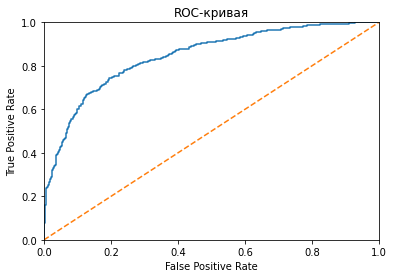

In [84]:
probabilities_valid = best_model_Rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [85]:
# Посчитаем значение AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Значение AUC-ROC наилучшей модели случайного леса:', round((auc_roc),3))

Значение AUC-ROC наилучшей модели случайного леса: 0.845


## Общий вывод

Было проведено исследование, чтобы спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам надо было построить модель с предельно большим значением F1-меры.  
В нашем распоряжении данные о поведении клиентов и расторжении договоров с банком.  
В ходе работы была выполнена предобработка данных.  
Привели названия столбцов к нижнему регистру. Заполним пропуски в столбце 'tenure' медианным значением. Признаки 'rownumber' - индекс строки датафрейма, 'customerid' и 'surname' - идентификаторы клиента - не несут ценности для обучения будущей модели, поэтому мы их удалили.  
В столбцах 'gender' и 'geography' преобразовали категориальные признаки в численные с помощью техники прямого кодирования OHE. Это позволило нам работать со всеми моделями. Столбец 'geography' содержал 3 класса, 'gender'- 2 класса. В результате мы получили только 2 и 1 столбцов соответственно, что позволяет избежать дами-ловушки.  
Спрятанной тестовой выборки нет. Данные разбили на три части: обучающую, валидационную и тестовую в пропорции 60:20:20.  
Чтобы алгоритмам было легче обучать модели, привели признаки к одному масштабу с помощью метода стандартизации данных StandardScaler. В результате мы получили масштабированные признаки для трех выборок. Масштаб у всех признаков стал одинаковый.  
В наших данных имелся дисбаланс 1:4. Доля отрицательных ответов около 80% , положитительных - чуть больше 20%.  
Были исследованы модели Decision Tree Classifier, RandomForestClassifier и Logistic Regression без учета дисбаланса данных. 
На несбалансированных выборках лучшие результаты у RandomForestClassifier - мера F1 = 0.56. Самое высокое значение AUC-ROC у наилучшей модели дерева решений - 0.5.  
Чтобы увеличить качество модели при дисбалансе классов, применили техники: взвешивание классов, upsampling и downsampling. Применив технику downsampling, данных стало сильно мало, это могло привести к переобучению. Поэтому стали применять технику upsampling для дальнейшей проверки моделей.  
Исследовали class_weight='balanced' как отдельную методику борьбы с дисбалансом и проверили на каждой модели. Техника upsampling и методика class_weight='balanced' дали на выходе одинаковые показатели меры F1 лучших моделей. Мера F1 всех моделей стала больше.  
Были исследованы модели Decision Tree Classifier, RandomForestClassifier и Logistic Regression с учетом дисбаланса данных. Самое высокое значение AUC-ROC у наилучшей модели Logistic Regression - 0.5.  Самый лучший показатель F1 у RandomForestClassifier - 0.61, с лучшим значением n_estimators = 21  и лучшим значением max_depth = 10. Выбрали эту модель для финального тестирования.  
На тестовой выборке F1 у лучшей модели RandomForestClassifier - 0.63.  
Построили ROC-кривую для лучшей модели RandomForestClassifier и изобразили её на графике. Также посчитали значение AUC-ROC наилучшей модели RandomForestClassifier: 0.845.  
Проверили нашу модель на адекватность, используя модель DummyClassifier. F1 модели DummyClassifier ниже, чем у нашей лучшей модели RandomForestClassifier. Наша модель адекватна и эффективна.
